In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Dataset shape: (1025, 14)

Missing values:
 age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

Class distribution:
 target
1    526
0    499
Name: count, dtype: int64


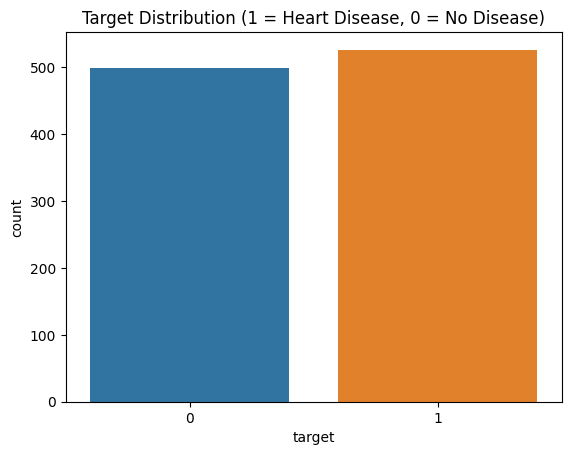

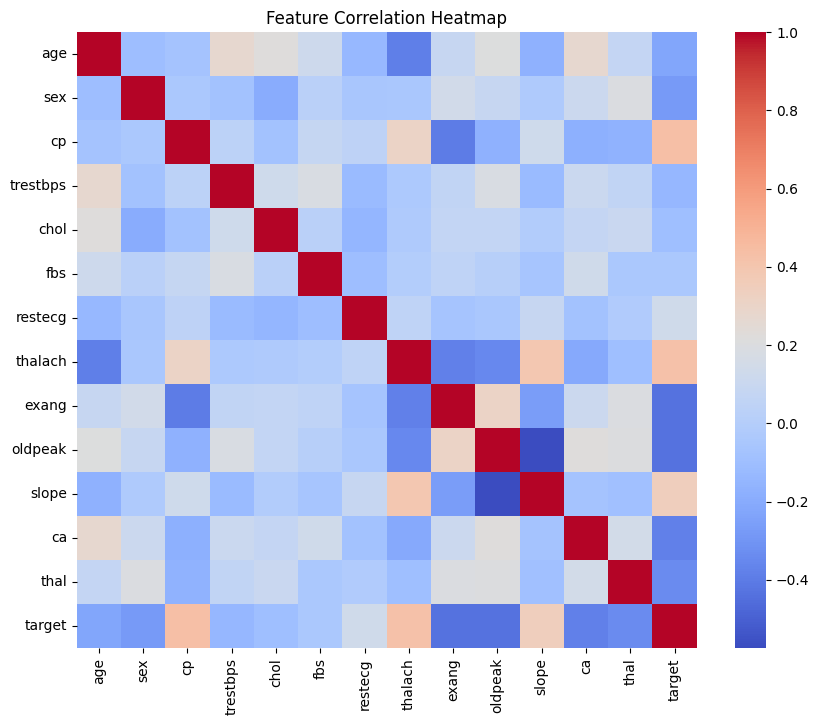

Train shape: (820, 13) Valid shape: (205, 13)

Logistic Regression Results:
Accuracy: 0.8097560975609757
ROC-AUC: 0.9298095238095239
Confusion Matrix:
 [[70 30]
 [ 9 96]]
Classification Report:
               precision    recall  f1-score   support

           0     0.8861    0.7000    0.7821       100
           1     0.7619    0.9143    0.8312       105

    accuracy                         0.8098       205
   macro avg     0.8240    0.8071    0.8066       205
weighted avg     0.8225    0.8098    0.8072       205


SVM Results:
Accuracy: 0.926829268292683
ROC-AUC: 0.9771428571428571
Confusion Matrix:
 [[91  9]
 [ 6 99]]
Classification Report:
               precision    recall  f1-score   support

           0     0.9381    0.9100    0.9239       100
           1     0.9167    0.9429    0.9296       105

    accuracy                         0.9268       205
   macro avg     0.9274    0.9264    0.9267       205
weighted avg     0.9271    0.9268    0.9268       205


Random Forest Resu

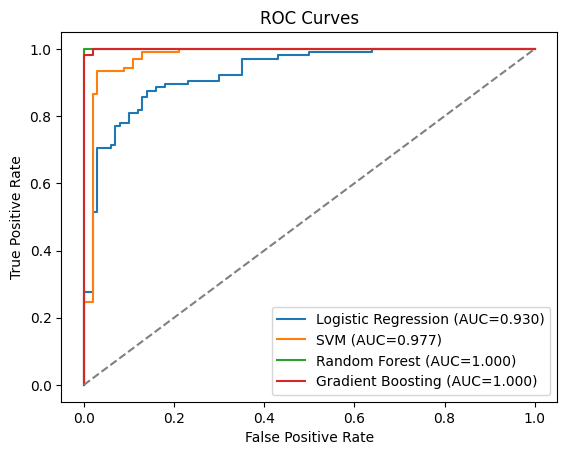


Model Comparison:
                 Model  Accuracy   ROC-AUC
2        Random Forest  1.000000  1.000000
3    Gradient Boosting  0.980488  0.999619
1                  SVM  0.926829  0.977143
0  Logistic Regression  0.809756  0.929810


In [2]:
# Heart Disease Prediction – Single Notebook
# Concepts: Binary classification, medical ML applications
# Algorithms: Logistic Regression, SVM, Random Forest, Gradient Boosting

# =========================
# 1) Imports
# =========================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, roc_auc_score, confusion_matrix, classification_report, roc_curve
)

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

RANDOM_STATE = 42

# =========================
# 2) Load Dataset
# =========================
# Adjust path if different in Kaggle
DATA_PATH = "/kaggle/input/heart-disease-dataset/heart.csv"
df = pd.read_csv(DATA_PATH)

print("Dataset shape:", df.shape)
df.head()

# =========================
# 3) Quick EDA
# =========================
print("\nMissing values:\n", df.isnull().sum())
print("\nClass distribution:\n", df['target'].value_counts())

sns.countplot(x="target", data=df)
plt.title("Target Distribution (1 = Heart Disease, 0 = No Disease)")
plt.show()

# Correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=False, cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.show()

# =========================
# 4) Features & Target
# =========================
X = df.drop("target", axis=1)
y = df["target"]

# Split
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

print("Train shape:", X_train.shape, "Valid shape:", X_valid.shape)

# Standardize numeric features (important for Logistic Regression & SVM)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

# =========================
# 5) Model Training
# =========================
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=RANDOM_STATE),
    "SVM": SVC(probability=True, kernel="rbf", random_state=RANDOM_STATE),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=200, random_state=RANDOM_STATE)
}

results = []

for name, model in models.items():
    # Fit
    if name in ["Logistic Regression", "SVM"]:
        model.fit(X_train_scaled, y_train)
        y_prob = model.predict_proba(X_valid_scaled)[:, 1]
        y_pred = model.predict(X_valid_scaled)
    else:
        model.fit(X_train, y_train)
        y_prob = model.predict_proba(X_valid)[:, 1]
        y_pred = model.predict(X_valid)
    
    # Metrics
    acc = accuracy_score(y_valid, y_pred)
    roc = roc_auc_score(y_valid, y_prob)
    
    results.append({"Model": name, "Accuracy": acc, "ROC-AUC": roc})
    
    print(f"\n{name} Results:")
    print("Accuracy:", acc)
    print("ROC-AUC:", roc)
    print("Confusion Matrix:\n", confusion_matrix(y_valid, y_pred))
    print("Classification Report:\n", classification_report(y_valid, y_pred, digits=4))
    
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_valid, y_prob)
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc:.3f})")

plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend()
plt.show()

# =========================
# 6) Compare Models
# =========================
results_df = pd.DataFrame(results).sort_values("ROC-AUC", ascending=False)
print("\nModel Comparison:")
print(results_df)

# Save results
results_df.to_csv("heart_disease_results.csv", index=False)
